In [181]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler

%matplotlib inline

In [182]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Check TensorFlow

In [183]:
print(tf.__version__)

2.3.0


### Get VTI history

In [184]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

In [185]:
vti_close_hist = vti_hist.Close

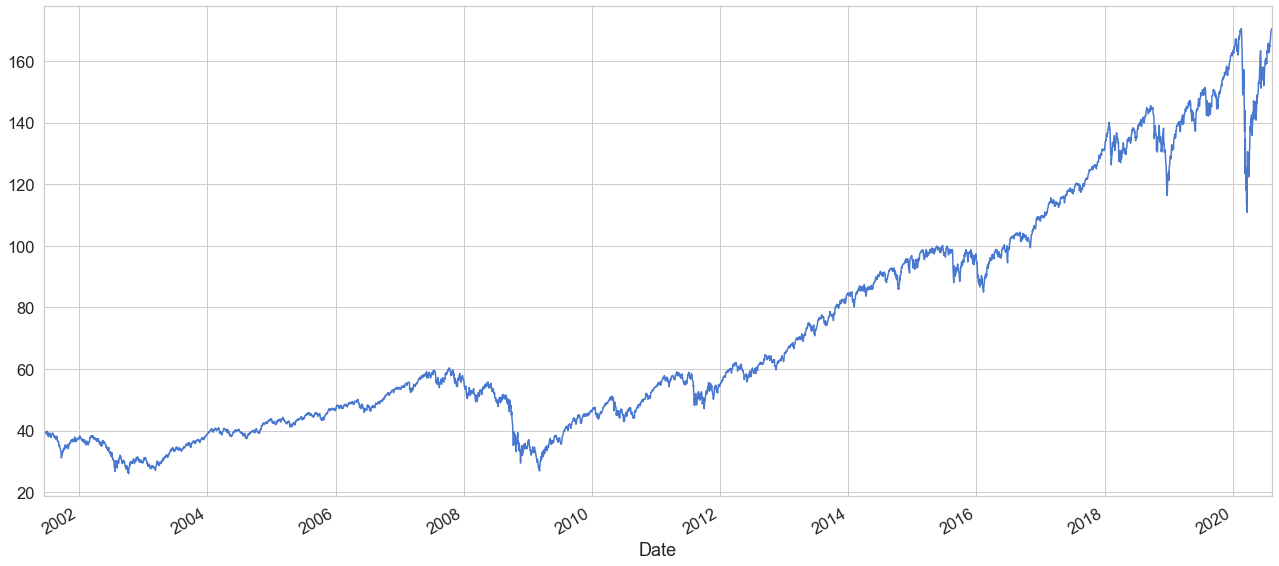

In [186]:
vti_close_hist.plot()

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [187]:
microsoft = yf.Ticker('MSFT').history(period="max")
apple = yf.Ticker('AAPL').history(period="max")
amazon = yf.Ticker('AMZN').history(period="max")
facebook = yf.Ticker('FB').history(period="max")
alphabetA = yf.Ticker('GOOGL').history(period="max")
alphabetC = yf.Ticker('GOOG').history(period="max")
johnson = yf.Ticker('JNJ').history(period="max")
berkshire = yf.Ticker('BRK-B').history(period="max")
visa = yf.Ticker('V').history(period="max")
proctor = yf.Ticker('PG').history(period="max")

#### Get DOW

In [188]:
dow = yf.Ticker('DJIA').history(period="max")

#### Get Gooogle Trends data

In [189]:
g_trends = pd.read_csv('vti_g_trends.csv')

#### Convert google trends date format and upsample

In [190]:
g_trends.columns = g_trends.iloc[0]
g_trends = g_trends[1:]

#### Combine into DF

In [191]:
df = pd.concat([vti_hist.Close.rename('vti'),
                     microsoft.Close.rename('msft'),
                     apple.Close.rename('appl'),
                     amazon.Close.rename('amzn'),
                     facebook.Close.rename('fb'),
                     alphabetA.Close.rename('google'),
                     alphabetC.Close.rename('googlb'),
                     johnson.Close.rename('jnj'),
                     berkshire.Close.rename('brk'),
                     visa.Close.rename('visa'),
                     proctor.Close.rename('pg'),
                     dow.Close.rename('dow')], join='outer', axis=1)


#### truncate to dates when vti is in existance

In [192]:
df = df.loc['2001-06-15':]

In [193]:
df.head()

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow
Date,,,,,,,,,,,,
2001-06-15,38.98,21.76,1.26,12.49,NaN,NaN,NaN,31.53,43.76,NaN,17.47,10623.64
2001-06-18,38.73,21.40,1.25,11.83,NaN,NaN,NaN,31.52,44.19,NaN,17.34,10645.38
2001-06-19,38.84,21.54,1.25,11.36,NaN,NaN,NaN,32.28,43.90,NaN,17.42,10596.67
2001-06-20,39.25,22.21,1.34,12.53,NaN,NaN,NaN,32.48,43.78,NaN,17.46,10647.33
2001-06-21,39.56,22.34,1.39,13.08,NaN,NaN,NaN,32.12,43.02,NaN,17.40,10715.43


### For holdings that didn't exist yet, fill NAs with its minimum price

In [194]:
for col in df.columns:
    df[col].fillna(df[col].min(), inplace=True)

In [195]:
df.head()

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow
Date,,,,,,,,,,,,
2001-06-15,38.98,21.76,1.26,12.49,17.73,50.06,49.82,31.53,43.76,8.48,17.47,10623.64
2001-06-18,38.73,21.40,1.25,11.83,17.73,50.06,49.82,31.52,44.19,8.48,17.34,10645.38
2001-06-19,38.84,21.54,1.25,11.36,17.73,50.06,49.82,32.28,43.90,8.48,17.42,10596.67
2001-06-20,39.25,22.21,1.34,12.53,17.73,50.06,49.82,32.48,43.78,8.48,17.46,10647.33
2001-06-21,39.56,22.34,1.39,13.08,17.73,50.06,49.82,32.12,43.02,8.48,17.40,10715.43


## Modeling

#### Train Test Split

In [196]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

4337 482


In [197]:
f_columns = df.columns.drop('vti')

f_transformer = RobustScaler()
vti_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
vti_transformer = vti_transformer.fit(train[['vti']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['vti'] = vti_transformer.transform(train[['vti']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['vti'] = vti_transformer.transform(test[['vti']])

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [132]:
train

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow
Date,,,,,,,,,,,,
2001-06-15,-0.324126,-0.004722,-0.316335,-0.386668,0.000000,-0.558456,-0.569717,-0.340974,-0.515544,-0.164709,-0.944107,-0.249296
2001-06-18,-0.329673,-0.025970,-0.316465,-0.388982,0.000000,-0.558456,-0.569717,-0.341206,-0.509209,-0.164709,-0.948438,-0.245720
2001-06-19,-0.327232,-0.017707,-0.316465,-0.390630,0.000000,-0.558456,-0.569717,-0.323565,-0.513482,-0.164709,-0.945773,-0.253733
2001-06-20,-0.318136,0.021839,-0.315292,-0.386528,0.000000,-0.558456,-0.569717,-0.318923,-0.515250,-0.164709,-0.944440,-0.245399
2001-06-21,-0.311259,0.029512,-0.314640,-0.384599,0.000000,-0.558456,-0.569717,-0.327279,-0.526448,-0.164709,-0.946439,-0.234196
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-04,2.007987,5.145049,2.569390,6.721194,3.193631,2.392924,2.418840,1.887309,1.934581,3.118970,1.080716,2.272478
2018-09-05,1.997560,4.959126,2.550490,6.564486,3.110787,2.361892,2.391434,1.934660,1.967143,2.998032,1.099375,2.276182
2018-09-06,1.988020,4.973882,2.502525,6.436461,3.013998,2.323489,2.352253,1.956943,1.976278,3.040968,1.079384,2.279617


In [198]:
#timeseries version of train test split
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [199]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.vti, time_steps)
X_test, y_test = create_dataset(test, test.vti, time_steps)

print(X_train.shape, y_train.shape)

(4327, 10, 12) (4327,)


In [200]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [201]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
122/122 [==============================] - 2s 13ms/step - loss: 0.0172 - val_loss: 0.1063
Epoch 2/30
122/122 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.1709
Epoch 3/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.0753
Epoch 4/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 5/30
122/122 [==============================] - 1s 7ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 6/30
122/122 [==============================] - 1s 8ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 7/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0067 - val_loss: 0.0186
Epoch 8/30
122/122 [==============================] - 1s 8ms/step - loss: 0.0088 - val_loss: 0.0744
Epoch 9/30
122/122 [==============================] - 1s 8ms/step - loss: 0.0077 - val_loss: 0.1068
Epoch 10/30
122/122 [==============================] - 1s 8ms/step - loss: 0.0058 - val_loss: 0.09

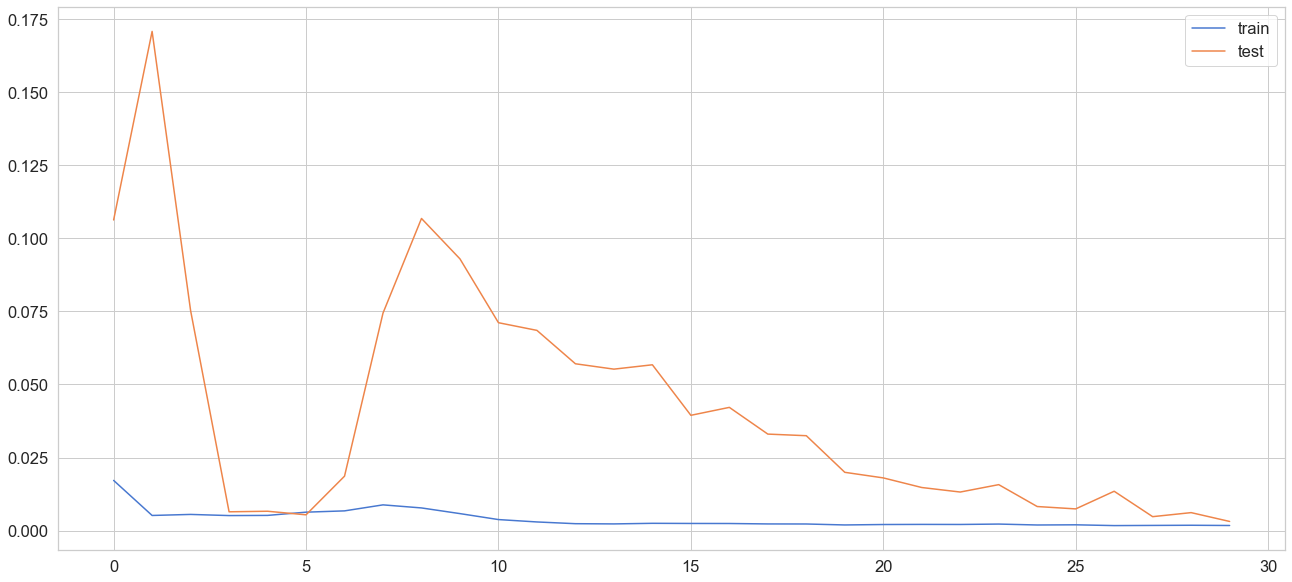

In [202]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [203]:
y_pred = model.predict(X_test)

In [204]:
y_train_inv = vti_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = vti_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = vti_transformer.inverse_transform(y_pred)

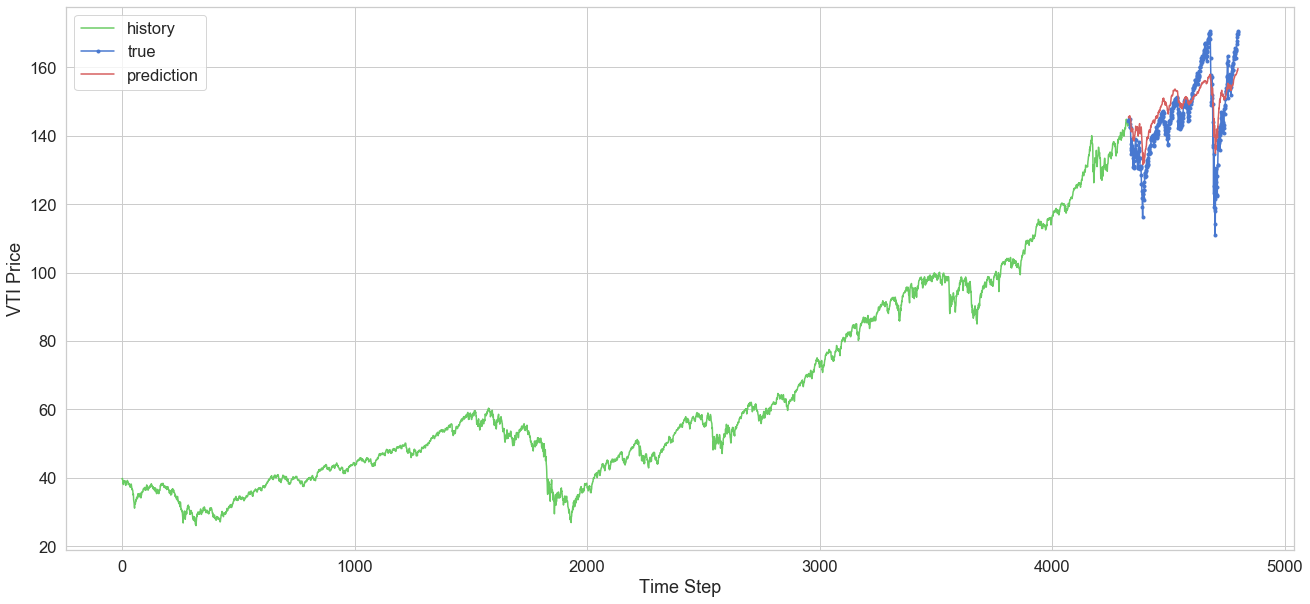

In [205]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

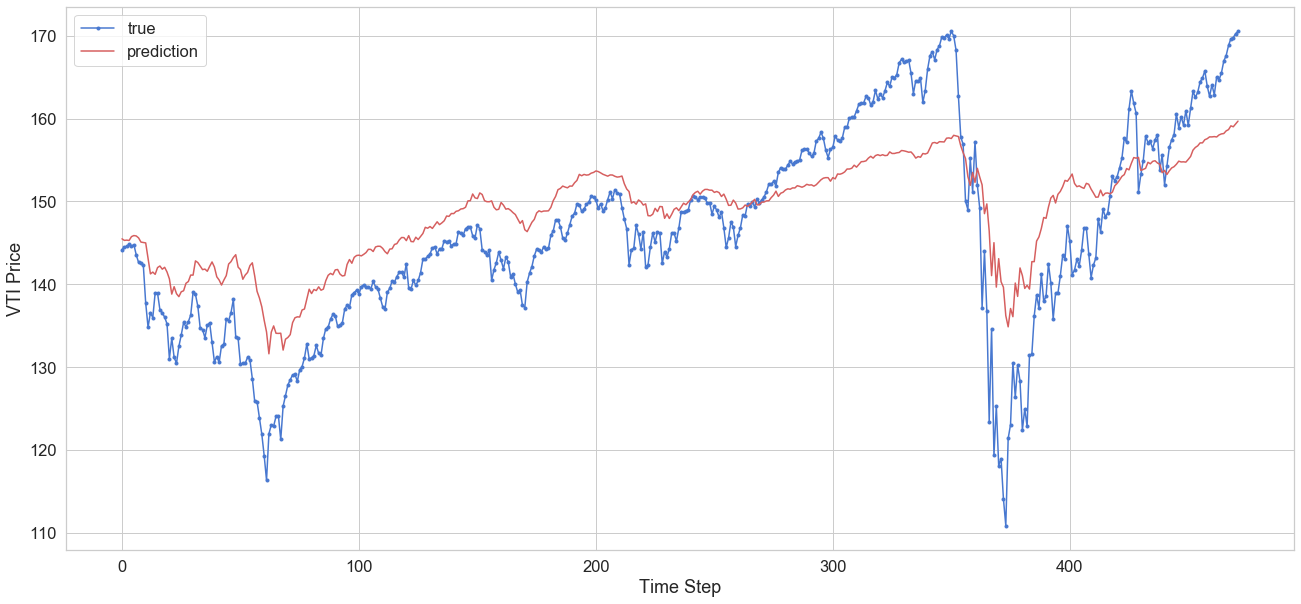

In [206]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();